# Table of Contents

* [Introduction](#introduction)
* [Imports and Functions](#chapter1)
* [Data Preparation](#chapter2)
    * [Normalizing the Data](#section_2_1)
    * [Writing the Data to the Specified Format](#section_2_2)
* [Multivariate Analysis](#chapter3)
    * [Preparation](#section_3_1)
    * [UMAP](#section_3_2)
    * [Clustering](#section_3_3)

# Introduction <a class="anchor" id="introduction"></a>

In this tutorial we will show you how to prepare the data once you have experimentally determined the projection values across the various angles you have selected as well as a brief demonstration of the multivariable analysis that is possible with the data you have reconstructed. For the second portion we will use data that was attained for Pogona Vitticeps, the bearded dragon which inhabits the lands of the land down under! 🦎

Data preparation involves normalizing the raw inputs. This will differ depending on the NGS technique that you have used. We should how this was done using the raw UMI counts that were attained from RNA sequencing experiments. The next important aspect is placing this data into the right format so that it can be handled by the Tomographer package.

There are several kinds of multivariate analysis that can be performed on the output data. Here we will implement a clustering algorithm of the pixels so that different regions of tissue can be discerned.

# Imports & Functions <a class="anchor" id="chapter1"></a>


In [1]:
%matplotlib inline
# from __future__ import division, print_function
from IPython.display import display


import os
os.environ["MKL_NUM_THREADS"] = "8" 
os.environ["NUMEXPR_NUM_THREADS"] = "8" 
os.environ["OMP_NUM_THREADS"] = "8" 

import numpy as np
import pandas as pd
import h5py
import re
import sys
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
import operator
import copy
import pickle


import community
from random import sample
import networkx as nx
from backspinpy import CEF_obj

# Tomography
import tomography
from tomography.utils import pad_to_cube, pad_to_square, shift_simmetrize
from brainmap import *
from tomography.core import build_Design_Matrix
from tomography import get_x, get_plate, colorize, normalize_AUC

# Sklearn, scipy
import umap

from skimage.exposure import rescale_intensity
import scipy.ndimage as sc
import scipy.sparse
from scipy.integrate import simps
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from skimage.segmentation import find_boundaries
from scipy import stats

from skimage.filters import gaussian
from skimage import exposure
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from skimage import morphology

from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, ward_tree
from scipy.cluster.hierarchy import ward, dendrogram, linkage, to_tree, dendrogram, fcluster
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from skimage.measure import find_contours
from skimage.morphology import convex_hull_image



from sklearn.decomposition import FactorAnalysis, NMF, non_negative_factorization, PCA

from helpers import *
sys.path.insert(0, os.path.abspath('../'))
from data_loaders import *

np.random.seed(11)

# Data Preparation <a class="anchor" id="chapter2"></a>


We will first load the raw data and put it into a format which can be analyzed by in-built functions of the Tomographer object.

The keys of the `data` dictionary are the angle names. The values of each key are now a dataframe, where the indexes are the gene names and the columns are the secondary slices within each angle.

In [2]:
# Load the data in a dictionary of pd.DataFrames
df_list = []
sample_id_list = []
for i in ["A","B","C","D","E"]:
    layout = pd.read_table("/data/TOMOGRAPHY/data/Lizard%s_layout.txt" % i, index_col=0, dtype=str)
    sample_id_list.append(layout.values.flatten(order="F"))
    cef = CEF_obj()
    cef.readCEF("/data/TOMOGRAPHY/data/Lizard%s_expression.cef" % i)
    df_list.append(pd.DataFrame(data = cef.matrix, index=cef.row_attr_values[0], columns=cef.col_attr_values[0]) )
    
sample_id = np.hstack(sample_id_list)
df = pd.concat(df_list,axis=1)
df.columns = sample_id
df = df.loc[:,sorted( df.columns.values )]

angles_name, angles_ix = np.unique( [i.split("_")[0] for i in df.columns], return_inverse=True )

data = {}
spikes = {}
for ix, angle in enumerate(angles_name):
    data[angle] = df.loc[:,angles_ix==ix].iloc[109:].astype(float)
    spikes[angle] = df.loc[:,angles_ix==ix].iloc[:109,:].astype(float)
    
del sample_id_list
del df_list

# add the expected x coordinate
for name_angle, df in data.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]
# do the same to the spikes
for name_angle, df in spikes.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]

### Plot profiles

We can begin to get a feel for the data by plotting the total molecules detected per projection, per angle (in blue). We can also try to understand where the spike-ins are (in green).

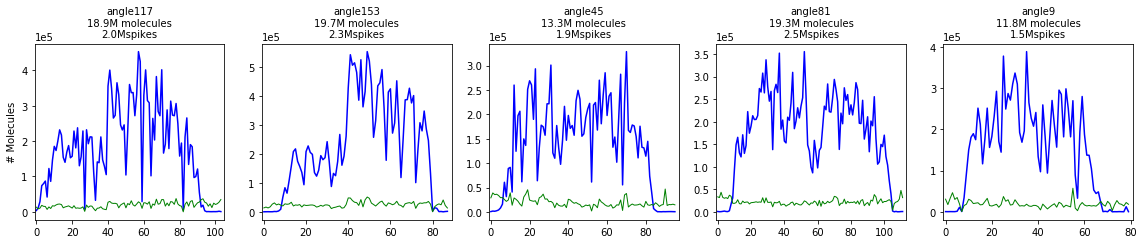

In [3]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_data_sum(data, spikes)

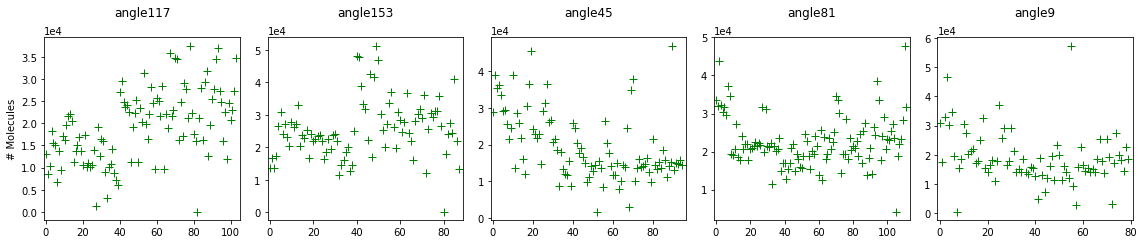

In [4]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_spikes(spikes)

We will now apply a gaussian process to this data to predicts its heteroscedacity. If a spike in is below a threshold, which is here defined as a value greater than a 1.96 times the standard deviation, we will remove it.

Once low spike-ins have been removed, we will again use a gaussian process to normalize the spikes.

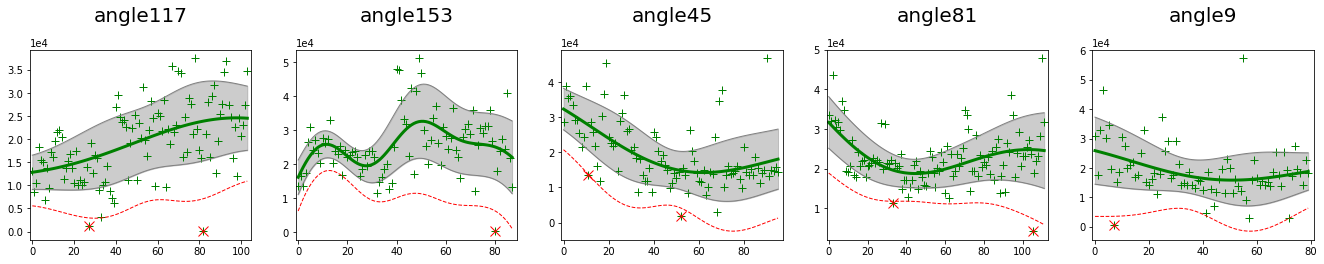

In [5]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_spikes = {}
for i, (name_angle, spikes_df) in enumerate(spikes.items()):
    # Prepare model fit
    x = np.arange(0,spikes_df.shape[1], dtype=float)
    y = spikes_df.sum(0).values
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_spikes[name_angle] = flag
    
    # Plot
    plt.subplot(151+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag)
    
    
# Remove low spikes
for name_angle in data.keys():
    data[name_angle] = data[name_angle].loc[:, ~(flag_low_spikes[name_angle])]
    spikes[name_angle] = spikes[name_angle].loc[:, ~(flag_low_spikes[name_angle])]

## Normalizing the Data <a class="anchor" id="section_2_1"></a>


We will clean up low counts that deviate significantly. Once the data is clean, we can AUC (Area Under the Curve) normalize it using the `normalize_AUC` function from the tomographer module.

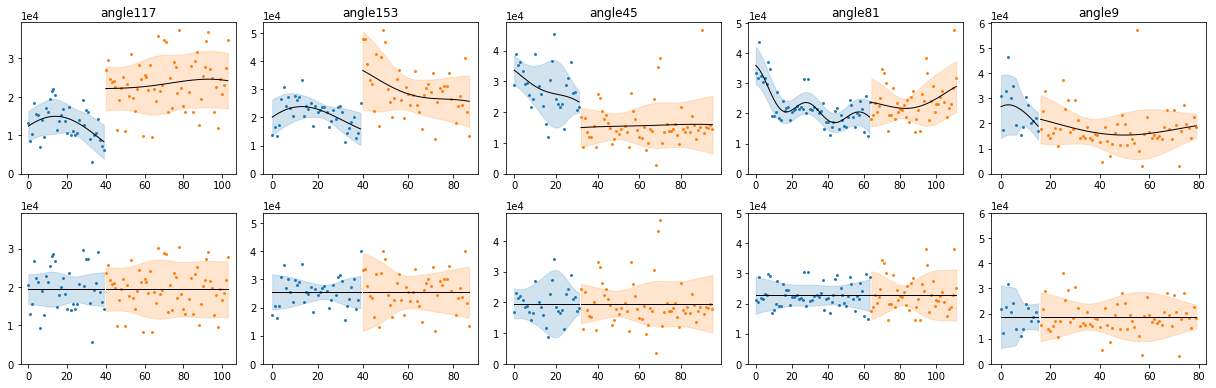

In [6]:
# Calculate adjustment parameters
coordinates_dict, adjustments = tomography.use_gp_to_adjust_spikes_diff(spikes, q=0.3)

plt.figure(figsize=(17,5.5))
tomography.plot_spikes_adjustment(coordinates_dict)


# perform normalization
data_norm = {}
for name_angle in data.keys():
    data_norm[name_angle] = data[name_angle].copy()
    
for name_angle in data_norm.keys():
    data_norm[name_angle] *= adjustments[name_angle]

### Check data

We will now use our normalized data to fit another gaussian process to see if our normalization worked as expected. We see that the data is looking much more continuous.

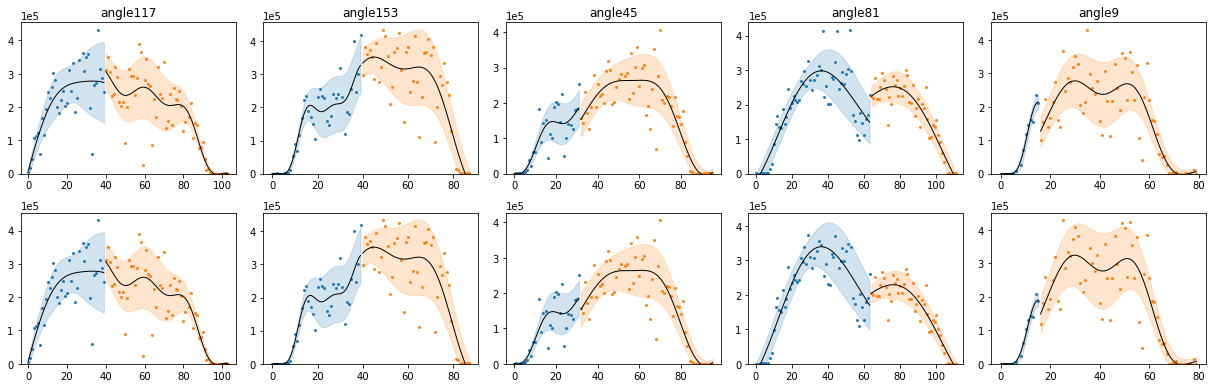

In [7]:
np.random.seed(15071990)
coordinates_dict, _ = tomography.use_gp_to_adjust_plates_diff(data_norm, q=0.3)

plt.figure(figsize=(17,5.5))
tomography.plot_plate_adjustment(coordinates_dict)

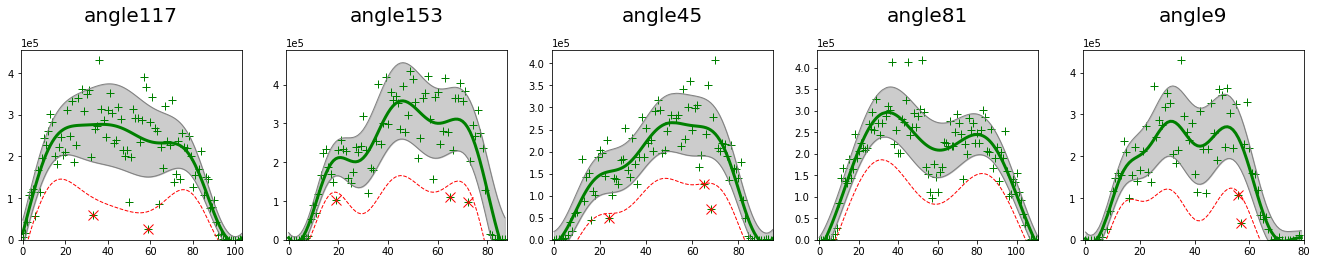

In [8]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_sample = {}
for i, (name_angle, df) in enumerate(data_norm.items()):
    # Prepare model fit
    x = get_x(df)
    y = df.sum(0).values
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_sample[name_angle] = flag
    
    # Plot
    plt.subplot(151+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag_low_sample[name_angle])
    plt.ylim(0,)
    
# remove flagged data points
for name_angle in data_norm.keys():
    data_norm[name_angle] = data_norm[name_angle].loc[:,~(flag_low_sample[name_angle]) ]

In [9]:
# AUC normalize
data_norm = normalize_AUC(data_norm)

We will now check if the primary slices are similar enough. This is an important assumption of the methodology, as the technique is prone to failure if this assumption is not satisfied.

The scatterplots demonstrate that molecule counts are similar across the primary slices.

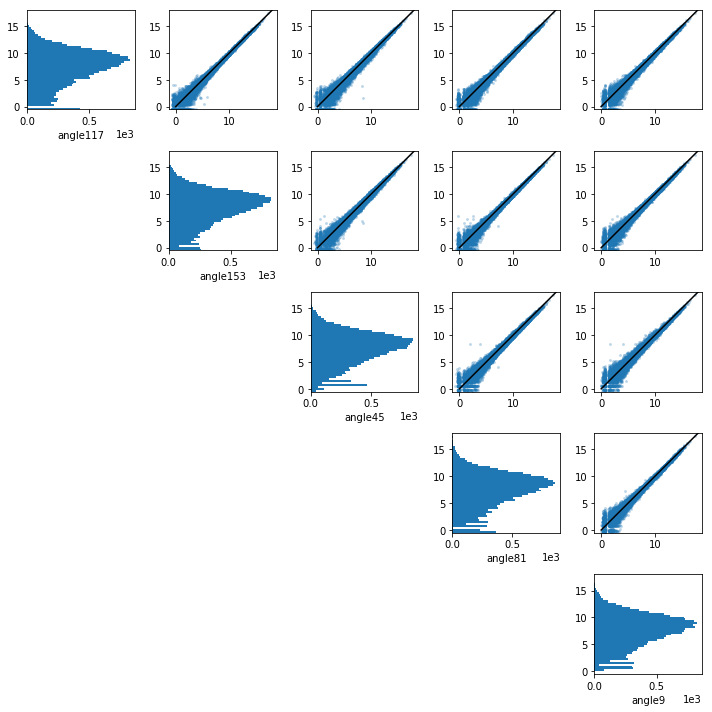

In [10]:
plt.figure(figsize=(10,10))
gs = plt.GridSpec(5,5)
for i, name_angle1 in enumerate(data_norm.keys()):
    for j, name_angle2 in enumerate(data_norm.keys()):
        if i < j:
            ax = plt.subplot(gs[i,j]) 
            ax.scatter(np.log2(data_norm[name_angle2].sum(1) + 1e-6),
                       np.log2(data_norm[name_angle1].sum(1) + 1e-6),
                       lw=0, s=8,alpha=0.3)
            ax.plot(np.arange(20),np.arange(20), c="k")
            plt.axis("equal")
            plt.xlim(-0.5, 18)
            plt.ylim(-0.5, 18)
        if i == j:
            ax = plt.subplot(gs[i,j]) 
            v = np.log2(data_norm[name_angle1].sum(1))
            ax.hist(v[np.isfinite(v)],bins=50,orientation="horizontal")
            plt.xlabel(name_angle1)
            plt.ylim(-0.5,18)
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

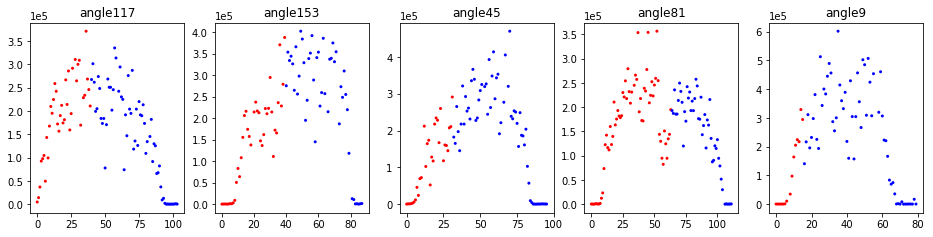

In [11]:
plt.figure(figsize=(16,3.5))
gs = plt.GridSpec(1,5)
for i, name_angle in enumerate(data_norm.keys()):
    ax = plt.subplot(gs[i])
    x = get_x(data_norm[name_angle])
    y = data_norm[name_angle].sum(0)
    c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    ax.scatter(x,y, marker=".",lw=0, c=c)
    ax.set_title("%s" % name_angle)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    
degrees_dict = {'angle117':117,'angle45':45,'angle9':9,'angle153':-27, 'angle81':81}
angles_dict = {}
for k, v in degrees_dict.items():
    angles_dict[k] = np.deg2rad(v+180.)
angles = np.array( [angles_dict[i] for i in data_norm.keys()] )

widths_dict = {'angle117':1,'angle45':1,'angle9':1,'angle153':1, 'angle81':1}
widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

(-0.5, 155.5, 155.5, -0.5)

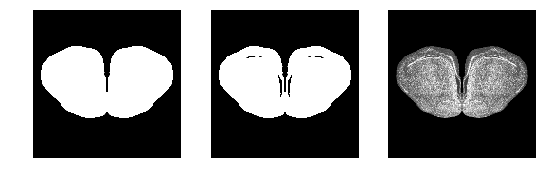

In [12]:
ref_im = pickle.load(open("/data/TOMOGRAPHY/data/ref_imgs_MT.pickle", "rb"))
mask_img = pickle.load(open("/data/TOMOGRAPHY/data/mask_img.pickle", "rb"))
mask_img_holes = pickle.load(open("/data/TOMOGRAPHY/data/mask_img_holes.pickle", "rb"))
reference_img = pickle.load(open("/data/TOMOGRAPHY/data/reference_img.pickle", "rb"))
ref_im["TOTAL"] = reference_img  #mask_img# 

plt.figure(figsize=(9,3))
ax = plt.subplot(131)
_= ax.imshow(mask_img, interpolation="none",cmap="gray")
plt.axis("off")
ax = plt.subplot(132)
_= ax.imshow(mask_img_holes, interpolation="none",cmap="gray")
plt.axis("off")
ax = plt.subplot(133)
_= ax.imshow(reference_img, interpolation="none",cmap="gray")
plt.axis("off")
#plt.savefig("../outputs/masj_reference.pdf",bbox_inches="tight")

In [13]:
D, projs_len = build_Design_Matrix(angles, widths, mask_img)
boundaries = np.r_[0,np.cumsum(projs_len)]
first_points = {'angle117':0,'angle45':4,'angle9':6,'angle153':8, 'angle81':6}

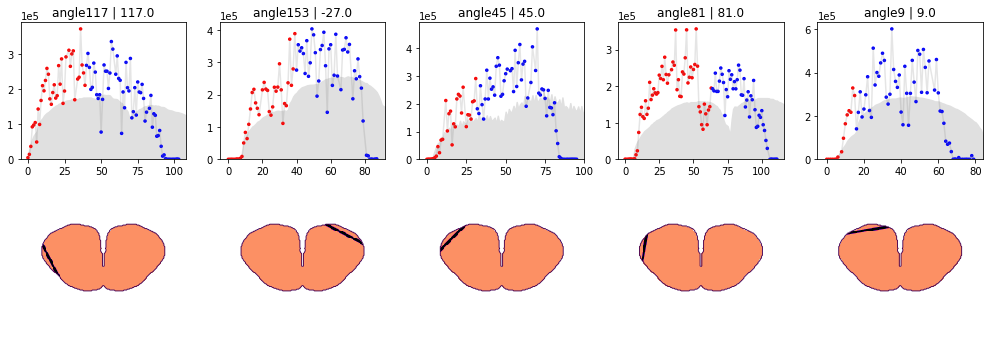

In [15]:
fig = plt.figure(figsize=(14,5.))
gs = plt.GridSpec(2,5)
import copy
palette = copy.copy(plt.cm.magma_r)
palette.set_under('w', alpha=0.0)

for i, (name_angle, df_angle) in enumerate(data_norm.items()):
    projected_total = D.dot(mask_img.flat[:])[boundaries[i]:boundaries[i+1]]
    ratio_factor = simps(df_angle.sum(0), get_x(df_angle)) / projected_total.sum()
    x = get_x(df_angle)
    y = data_norm[name_angle].sum(0)
    c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    
    # Set the plot
    ax = plt.subplot(gs[0,i])
    # Plot points
    ax.scatter(x, y, c=c, marker=".", lw=0, s=50)
    ax.plot(x, y, alpha=0.2, c="gray")
    # Plot expected projection 
    #ax.plot(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, c="k",lw=1.5,zorder=1000)
    ax.fill_between(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, color="0.88",lw=1.5,zorder=-1)
    # Fix graphics
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title("%s | %s" % (name_angle, angles[i]/(np.pi/180.)-180))
    ax.set_xlim(-5,get_x(df_angle)[-1]+5)
    ax.set_ylim(-0.2,)
    
    #Set the plot
    ax = plt.subplot(gs[1,i])
    s, e = boundaries[i],boundaries[i+1]
    a,b = np.array([5,8]) + s
    ax.imshow( (0.5*D[s:e].sum(0)+D[a:b,:].sum(0)).reshape(mask_img.shape[0], mask_img.shape[1]), cmap=palette, vmin=0.2 )
    ax.contour(mask_img, [0.5], linewidths=[0.9])
    plt.axis("off")
    # Plot first 3 slides
plt.tight_layout();
#plt.savefig("../outputs/placeholder_total.pdf", bbox_inches="tight")

## Optimizing Overlap

It can be that the precise values for the angles and widths are not as perfect as the experimentalist would have liked them to be. We will now determine what these precise values are.

In [16]:
# Add a dummy gene "TOTAL" to mantain the same API
for angle in angles_dict.keys():
    data_norm[angle].loc["TOTAL",:] = data_norm[angle].loc[data_norm[angle].index != "TOTAL",:].sum(0) # written like this avoids problems if run twice
    manual_shift = {'angle9': -6, 'angle45': -5, 'angle81': -7, 'angle117': 0, 'angle153': -7}
prior_avgs = {k:np.rad2deg(v) for k,v in angles_dict.items()}
# prior_fp = {k:-v for k,v in manual_shift.items()}
# Found manually but very straightforward from the plots

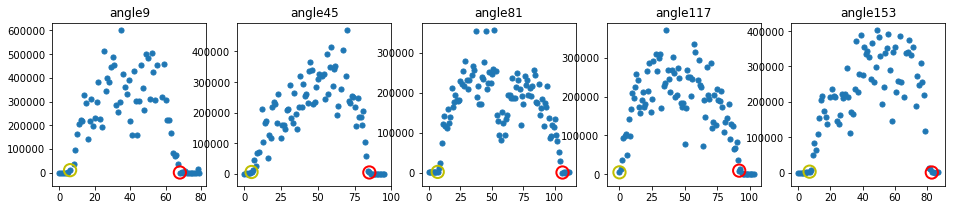

In [17]:
conv_hull = morphology.convex_hull_image(mask_img >= 0.2)  # Note: before 0.05
heuristic_wid = {}
extreme_angle_wid = {}
plt.figure(None, (16,3))
gs = plt.GridSpec(1, 5)
for i, angle_set in enumerate(["angle9", "angle45", "angle81", "angle117", "angle153"]):
    p = -manual_shift[angle_set]
    p_s, p_e = np.maximum(p - 3, 0), np.minimum(len(data_norm[angle_set].ix["TOTAL"].values)-1, p+2)
    thrs = np.mean( data_norm[angle_set].ix["TOTAL"].values[p_s:p_e])
    end_ix = np.where(np.diff((data_norm[angle_set].ix["TOTAL"].values > thrs).astype(int))==-1)[0][0]
    _x = get_x(data_norm[angle_set])
    end_ix = np.minimum(end_ix+1, len(_x)-1)
    n_slices = _x[end_ix] - _x[p] + 1
    angles_x = (np.pi - np.deg2rad(prior_avgs[angle_set] + np.arange(-10,10+1))) % (2 * np.pi)
    extensions = [tomography.core.all_slicing_parameters(conv_hull, angle_a)[4] for angle_a in angles_x]
    wmin = np.min(extensions)/n_slices
    wmax = np.max(extensions)/n_slices
    heuristic_wid[angle_set] = wmin, wmax
    extreme_angle_wid[angle_set] = extensions[0]/n_slices, extensions[-1]/n_slices
    plt.subplot(gs[i])
    plt.scatter(_x, data_norm[angle_set].ix["TOTAL"].values, s=26)
    plt.scatter(_x[end_ix], data_norm[angle_set].ix["TOTAL"].values[end_ix], s=150, edgecolor="r", facecolor="", lw=2)
    plt.scatter(_x[p], data_norm[angle_set].ix["TOTAL"].values[p], s=150,edgecolor="y", facecolor="", lw=2)
    plt.title(angle_set)

In [19]:
D_cache = DCache(1. * (mask_img_holes>0.2))  # in alternative use mask_img

In [20]:
optimal_corr_dict = {}
optimal_L2_dict = {}
optimal_df = pd.DataFrame(columns=["angle", "widths", "shifts"])

# DATA
for angle_set in ['angle117', 'angle45', 'angle9', 'angle153', 'angle81']:
    optimal_corr_dict[angle_set] = pd.DataFrame(columns=["angle", "widths", "shifts"])
    optimal_L2_dict[angle_set] = pd.DataFrame(columns=["angle", "widths", "shifts"])

    for gene in ["TOTAL"]:  # ref_im.keys():
        print(angle_set, gene)
        x_raw = get_x(data_norm[angle_set])
        y_raw = data_norm[angle_set].ix[gene].values
        x, y = interpolate(x_raw, y_raw)

        # PREDICTED
        angles_probes = np.arange(prior_avgs[angle_set]-10, prior_avgs[angle_set]+10)
        wid_probes = np.round(np.arange(heuristic_wid[angle_set][0], heuristic_wid[angle_set][1]+0.02, 0.02), 3)
        
        fp = manual_shift[angle_set]
        record = grid_score_prediction(angles_probes, wid_probes, D_cache, ref_im[gene].flat[:], y, (fp, fp), return_ys=False)

        prior = 1 # gauss_kernel(angles_probes, prior_avgs[angle_set], 50)[:,None]
        # Optimum correltion
        arminsCor = np.argmin(record["corr_score"]/prior, 0)
        arminCor = np.argmin(record["corr_score"][arminsCor, np.arange(record["corr_score"].shape[1])])
        optimal_corr_dict[angle_set].loc[gene,:] = angles_probes[arminsCor[arminCor]], wid_probes[arminCor], record["x_shift"][arminsCor[arminCor], arminCor]
        # Optimum rss
        arminsL2 = np.argmin(record["L2_score"]/prior, 0)
        arminL2 = np.argmin(record["L2_score"][arminsL2, np.arange(record["L2_score"].shape[1])])
        optimal_L2_dict[angle_set].loc[gene,:] = angles_probes[arminsL2[arminL2]], wid_probes[arminL2], record["x_shift"][arminsL2[arminL2], arminL2]
        
        if gene == "TOTAL":
            optimal_df.loc[f"{angle_set}_corr",:] = angles_probes[arminsCor[arminCor]], wid_probes[arminCor], record["x_shift"][arminsCor[arminCor], arminCor]
            optimal_df.loc[f"{angle_set}_L2",:] = angles_probes[arminsL2[arminL2]], wid_probes[arminL2], record["x_shift"][arminsL2[arminL2], arminL2]

angle117 TOTAL
angle45 TOTAL
angle9 TOTAL
angle153 TOTAL
angle81 TOTAL


In [21]:
angles_optimum = np.deg2rad(np.array([optimal_df.loc[f"{angle_set}_corr"].values[0] for angle_set in data_norm.keys()]))
widths_optimum = np.array([optimal_df.loc[f"{angle_set}_corr"].values[1] for angle_set in data_norm.keys()])
first_points_optimum = [-optimal_df.loc[f"{angle_set}_corr"].values[2] for angle_set in data_norm.keys()]
first_points_opt_dict = {angle_set:-optimal_df.loc[f"{angle_set}_corr"].values[2] for angle_set in data_norm.keys()}

We now show what the corrected plots look like after we have determined the optimal values for widths and angles.

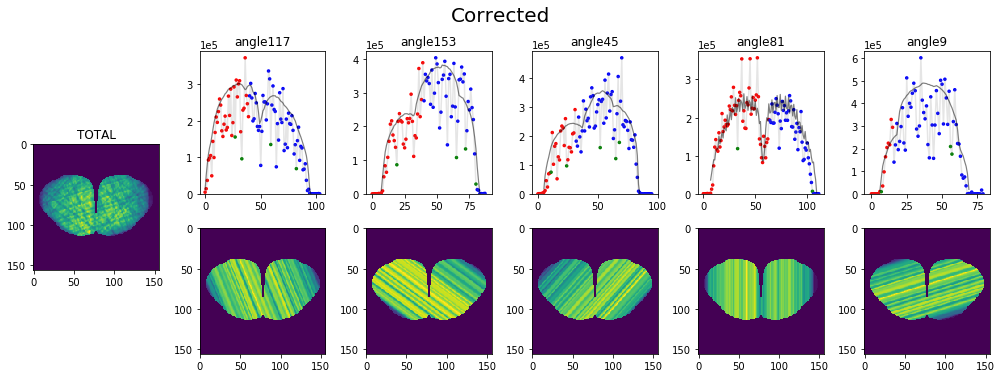

In [22]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("TOTAL", data_norm, angles_optimum, widths_optimum, first_points_opt_dict, mask_img)

## Writing Data to the Specified Format  <a class="anchor" id="section_2_2"></a>


The tomographer object requires two `.hdf5` files as input. One is the configuration file and the second is the file containing the gene values across projections. We will now create these two file types.

In [23]:
# creating configuration file
angles_names = list(data_norm.keys())
rec_conf = tomography.ReconstructionConfig(angles_names=angles_names,
                                     mask=mask_img_holes,
                                     mask_thrs=0.2,
                                     reference_mask=reference_img*mask_img_holes,
                                     symmetry=True,
                                     masked_formulation=True,
                                     angles_values=angles_optimum,
                                     first_points=first_points_optimum,
                                     widths=widths_optimum)

# creating dictionary of gene values
all_gene_values_dict = {gene:{name_angle:data_norm[name_angle].ix[gene].values for name_angle in data_norm.keys()} for gene in data_norm["angle81"].index}


In [26]:
# writing files to hdf5

# gene values file
f = h5py.File('Lizard_gene_values.hdf5', "w")
for i, (k, d) in enumerate(all_gene_values_dict.items()):
    for k2, v in d.items():
        f.create_dataset("/genes/%s/%s" % (k,k2), data=v)
for name_angle in data_norm.keys():
    f.create_dataset("coordinates/%s" % name_angle, data=get_x(data_norm[name_angle]) )
f.close()

#config file
rec_conf.to_file("Lizard_config.hdf5")

## Perform Reconstruction

We will now perform a test reconstruction for a single gene *TAC1*. 

In [27]:
tg = tomography.Tomographer()
tg.load_cfg(rec_conf)
tg.connect_data('Lizard_gene_values.hdf5')


result = tg.reconstruct('TAC1', alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)
    

 It might results in errors 
Filling with sorted(list(self.f["genes"].keys()))


The set cost function is ignored! LCB acquisition does not make sense with cost.
The set cost function is ignored! LCB acquisition does not make sense with cost.


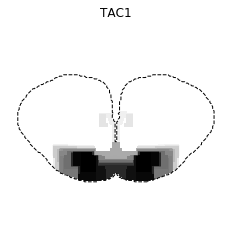

In [28]:
tomography.show_reconstruction_raw(result, mask_img)
plt.title('TAC1')
plt.show()

# Multivariate Analysis <a class="anchor" id="chapter3"></a>

## Loading and Preparation <a class="anchor" id="section_3_1"></a>

We will begin by loading the config file which was used as input for our reconstructions as well as the output reconstruction file. The reason we use the config file is because it contains parameters concerning the mask which are important for performing the multivariate analysis

In [2]:
# Read config files
config = h5py.File("../../../../outputs/Lizard_config_4Aug2017.hdf5", mode="r")
alpha_betas = h5py.File('/data/TOMOGRAPHY/outputs/LizardComparison_alpha_beta.hdf5', mode='r')
input_genes = h5py.File("../../../../outputs/gene_values_10May2017.hdf5", mode="r")
gene_file = h5py.File("/data/TOMOGRAPHY/outputs/LizardComparison.hdf5", mode="r")
reference_mask = config['reference_mask'][:]
mask = config['mask_g'][:]


reference_mask = config["reference_mask"][:]
config.close()

connectivity = tomography.create_connectivity(mask)

# List genes
genes = list(gene_file.keys())
N_genes= len(genes)

We will normalize the data in such a way that the values within pixels for a gene are representative of their gene expression level. We will also filter out genes which a high beta value was selected, since this indicates that the gene was reconstructed to be very flat. All reconstructed images are lightly blurred by a gaussian. This is all performed in the following cell.

In [4]:
graph = set_graph(mask)
X, selected_genes = create_X(mask, genes, alpha_betas, gene_file, graph)
X_normalized = normalize(selected_genes, input_genes, X)

Sometimes the reconstruction can result in NaN values due to numerical issues. We will filter out these 'bad indexes' from our dataset.

In [5]:
bad_idx = ~np.isnan(X_normalized.T).any(axis=1)
X_normalized = X_normalized.T[bad_idx].T
selected_genes = selected_genes[bad_idx]
selected_genes = [x.title() for x in selected_genes]

We will now select the mask that is within one half of the brain, since we assume gene expression is symmetrical and we do not want to count a pixel twice.

In [6]:
mask_idx = np.argwhere(mask >= 0.2)
mask_idx_1D = []
# convert mask idx from 2D to 1D number so matrix X can be indexed accordingly
for entry in mask_idx:
    if entry[1] < int(mask.shape[1] / 2):
        mask_idx_1D.append(entry[0] * mask.shape[0] + entry[1])
    
mask_idx_1D = np.array(mask_idx_1D)

X_mask = X_normalized[mask_idx_1D]
df = pd.DataFrame(X_mask, columns=selected_genes)

## Applying UMAP <a class="anchor" id="section_3_2"></a>

We can perform a dimensionality reduction on our data set. There can be thousands of genes, and this can pose issues for clustering the pixels. Here we perform a UMAP dimensionality reduction on the dataset, and colorcode the pixels according to the X axis so that we have an idea of where the pixels are in the image space.

In [8]:
np.random.seed(13)

reducer_ = umap.UMAP(n_components=2, n_neighbors=50, target_n_neighbors=30, learning_rate=15,
                     local_connectivity=50, min_dist=0.1, spread=2, repulsion_strength=10, metric='correlation')


embedding_ = reducer_.fit_transform(X_mask)

colors=["#F5B7B1", "#D7BDE2", "#A9CCE3", "#D1F2EB", "#F9E79F", "#D5DBDB", "#CB4335", "#6C3483",
       "#2874A6", "#148F77", "#717D7E", "#00FF00", "#00FFFF", "#FF00FF", "#F00000", "#0000FF", "#000000"]
axXs, axYs = np.meshgrid(np.arange(156), np.arange(156))
axXs2 = axXs.copy()
axXs2.flat[~(np.in1d(np.arange(156**2), mask_idx_1D))] = 0

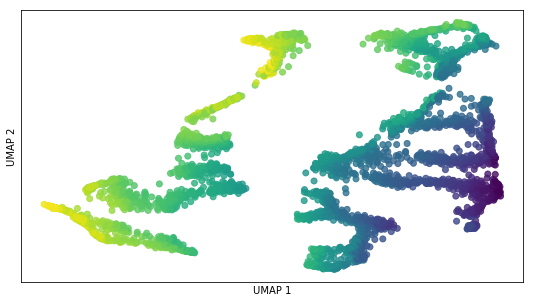

In [16]:
fig = plt.figure(figsize=(9,5))

plt.scatter(embedding_[:,1], embedding_[:,0],c= axXs.flatten()[mask_idx_1D], alpha=0.8)
plt.xticks([])
plt.yticks([])

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()

## Clustering <a class="anchor" id="section_3_3"></a>

We can take our data which has been compacted in this two dimensional space and perform clustering of the pixels. This way we may be able to identify regions of pixels that are more similar! Here we use the AgglomerativeClustering class from `scikit-learn` which allows us to easily implement ward clustering. 

In [17]:
n_clusters = 15 # 5 is a good number
ward_ = AgglomerativeClustering(n_clusters=n_clusters,
                               affinity='manhattan',
                               compute_full_tree=True,
                               linkage='average')
ward_.fit(embedding_)

AgglomerativeClustering(affinity='manhattan', compute_full_tree=True,
            connectivity=None, linkage='average', memory=None,
            n_clusters=15, pooling_func='deprecated')

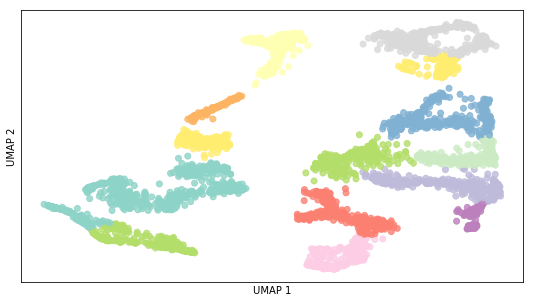

In [37]:
fig = plt.figure(figsize=(9,5))

plt.scatter(embedding_[:,1], embedding_[:,0],c= ward_.labels_, alpha=0.8, cmap='Set3')
plt.xticks([])
plt.yticks([])

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')

plt.show()